In [1]:
import os 
import ipyvolume as ipv
from tyssue import HistoryHdf5
from tyssue.draw import browse_history
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev
from scipy.optimize import curve_fit

from polarity.toolbox import open_sheet
import seaborn as sns

In [2]:
filename = '1.0_polarity_[1157, 232, 509]_perturbation_1324094.302695705_ve_0'
history = HistoryHdf5.from_archive(
    '/home/admin-suz/Documents/Code/polarity/notebooks/20200303-variability/'+filename+'/'+filename+'.hf5'
    )

specs = {
    "face": {
        "visible": True,
        "color":lambda sheet :sheet.face_df.fold,
        #"color": lambda sheet : sheet.face_df['ablate'],
        "colormap": 'Blues',
        "alpha": 0.2
    },
    "edge": {
        "visible": True,
        "color":'black',
    },
}


browse_history(history, coords=['z', 'x', 'y'], **specs)
ipv.style.use("dark")
ipv.style.box_off()
ipv.pylab.style.axes_off()

/home/admin-suz/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


interactive(children=(IntSlider(value=0, description='i', max=149), Output()), _dom_classes=('widget-interact'…

In [3]:
def update_latrad(sheet):
    radius_ = sheet.vert_df.eval("(x**2+y**2)**0.5")
    sheet.vert_df['depth'] = radius_.max() - radius_
    sheet.vert_df['latitude'] = np.arctan2(sheet.vert_df.y, sheet.vert_df.x)

In [4]:
from scipy.signal import find_peaks
from scipy.optimize import brentq

def get_slice(sheet, l0=0, largeur=0.3):
    """ l0 should be between -π and π
    
    """
    vert = sheet.vert_df[
        (sheet.vert_df.latitude<l0+largeur/2)
        & (sheet.vert_df.latitude>l0-largeur/2)
        & (sheet.vert_df.z>-30) & (sheet.vert_df.z<30)
    ].copy()
    return vert
    
def measure_fold(sheet, l0=0.0, largeur=0.3, t=None, window=40):
    
    if t is None:
        t = np.arange(-window/4, window/4+1, window/8)
    vert = get_slice(sheet, l0, largeur)
    vert.sort_values('z', inplace=True)
    tck = splrep(vert['z'], vert['depth'], t=t, k=3)
    zz = np.linspace(-window/2, window/2, 100)
    i_depth = splev(zz, tck)
    i_slope = splev(zz, tck, der=1)
    
    z_sl = zz[np.argmax(i_slope)]
    z_sr = zz[np.argmin(i_slope)]
    try:
        z_depth = brentq(lambda z: splev(z, tck, der=1), z_sl, z_sr)
    except ValueError:
        z_depth = np.nan
    
    measures = {
        "i_depth":i_depth,
        "depth" : i_depth.max(),
        "z_depth": z_depth,
        "slope_left" : i_slope.max(), 
        "slope_right" : -i_slope.min(),
        "z_sl" : z_sl,
        "z_sr" : z_sr,
    }
    
    return measures

def measure_fold_whole_sheet(sheet, nbins=100, **kwargs):
    update_latrad(sheet)
    all_measures = []
    lats = np.linspace(-np.pi, np.pi, nbins)
    for lat in lats:
        all_measures.append(measure_fold(sheet, l0=lat, **kwargs))
    
    all_measures = pd.DataFrame.from_records(all_measures)
    all_measures.index = lats
    return all_measures



In [5]:
SIM_DIR = '/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability'

list_dir = os.listdir(SIM_DIR)

In [6]:
def find_max_depth_time_v1(history):

    with pd.HDFStore(history.hf5file, "r") as file:
        v_pos = file.select("vert", columns=["time", "x", "y", "z"]).reset_index()
    center = v_pos[np.abs(v_pos['z']) < 25]
    sq_dpth = center.x**2 + center.y**2
    time = v_pos.loc[sq_dpth.idxmin()]['time']
    return time

def find_max_depth_time(history, window):
    with pd.HDFStore(history.hf5file, "r") as file:
        v_pos = file.select("vert", columns=["time", "x", "y", "z"]).reset_index()
    center = v_pos[np.abs(v_pos['z']) < window]
    center['distance'] = np.sqrt((center.x-center.x.mean())**2+(center.y-center.y.mean())**2)
    distances = center.groupby('time')['distance'].mean()
    time = distances.idxmin()
    return time

In [589]:
control = pd.DataFrame()

datas = pd.DataFrame()
for i in range (0,24):
    fig, ax = plt.subplots()
    trace = 1
    for d in range (0,13):
        for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[d])) if f.split('_')[-1] == str(i)):

            
            history = HistoryHdf5.from_archive(
                os.path.join(os.path.join(SIM_DIR,list_dir[d]),f+'/out.hf5')
    )
            
            #t = find_max_depth_time(history, 15)
            
            print(d, i, t)
            sheet = history.retrieve(90)
            
            
            all_measures = measure_fold_whole_sheet(sheet, nbins=24, window=40)
            all_measures.reset_index(drop=False, inplace=True)
            all_measures['pola'] = f.split('_')[0]
            all_measures['perturb'] = f.split('_')[2]
            all_measures['id'] = f.split('_')[-1]
            #datas=pd.concat([datas, all_measures], axis=0)
            
            
            sheet.face_df['latitude'] = np.arctan2(
                    sheet.face_df['y'],
                    sheet.face_df['x'],
                )

            if trace == 1:
                pos_perturb_latitude = sheet.face_df[sheet.face_df.is_mesoderm==1]['latitude']
                pos_perturb_z = sheet.face_df[sheet.face_df.is_mesoderm==1]['z']
                ax.scatter(
                    pos_perturb_latitude,
                    pos_perturb_z,
                    #c=sheet.vert_df['depth'].clip(upper=10),
                    alpha=1,
                    c='red'
                )
                trace = 0
            if d%2==0:
                ax.plot(all_measures.index, all_measures.z_depth, 'k')
            else : 
                ax.plot(all_measures.index, all_measures.z_depth, 'red')
            
            


            ax.set_ylim(-10, 10)
    plt.savefig(str(i)+'.png')
    plt.close('all')
            

#datas.to_csv("datas2.csv", sep=';')

0 0 48.0
1 0 48.0
2 0 48.0
3 0 48.0
4 0 48.0
5 0 48.0
6 0 48.0
7 0 48.0
8 0 48.0
9 0 48.0
10 0 48.0
11 0 48.0
0 1 48.0
1 1 48.0
2 1 48.0
3 1 48.0
4 1 48.0
5 1 48.0
6 1 48.0
7 1 48.0
8 1 48.0
9 1 48.0
10 1 48.0
11 1 48.0
0 2 48.0
1 2 48.0
2 2 48.0
3 2 48.0
4 2 48.0
5 2 48.0
6 2 48.0
7 2 48.0
8 2 48.0
9 2 48.0
10 2 48.0
11 2 48.0
0 3 48.0
1 3 48.0
2 3 48.0
3 3 48.0
4 3 48.0
5 3 48.0
6 3 48.0
7 3 48.0
8 3 48.0
9 3 48.0
10 3 48.0
11 3 48.0
0 4 48.0
1 4 48.0
2 4 48.0
3 4 48.0
4 4 48.0
5 4 48.0
6 4 48.0
7 4 48.0
8 4 48.0
9 4 48.0
10 4 48.0
11 4 48.0
0 5 48.0
1 5 48.0
2 5 48.0
3 5 48.0
4 5 48.0
5 5 48.0
6 5 48.0
7 5 48.0
8 5 48.0
9 5 48.0
10 5 48.0
11 5 48.0
0 6 48.0
1 6 48.0
2 6 48.0
3 6 48.0
4 6 48.0
5 6 48.0
6 6 48.0
7 6 48.0
8 6 48.0
9 6 48.0
10 6 48.0
11 6 48.0
0 7 48.0
1 7 48.0
2 7 48.0
3 7 48.0
4 7 48.0
5 7 48.0
6 7 48.0
7 7 48.0
8 7 48.0
9 7 48.0
10 7 48.0
11 7 48.0
0 8 48.0
1 8 48.0
2 8 48.0
3 8 48.0
4 8 48.0
5 8 48.0
6 8 48.0
7 8 48.0
8 8 48.0
9 8 48.0
10 8 48.0
11 8 48.0
0 9 48.0
1

In [101]:
datas = pd.DataFrame()

for d in range (0, 13):
    for i in range (0, 24):
        for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[d])) if f.split('_')[-1] == str(i)):

            
            history = HistoryHdf5.from_archive(
                os.path.join(os.path.join(SIM_DIR,list_dir[d]),f+'/out.hf5')
            )
            
            t = find_max_depth_time(history, 15)
            
            print(d, i, t)
            sheet = history.retrieve(t)
            
            
            all_measures = measure_fold_whole_sheet(sheet, nbins=24, window=40)
            all_measures.reset_index(drop=False, inplace=True)
            all_measures['pola'] = f.split('_')[0]
            all_measures['perturb'] = f.split('_')[2]
            all_measures['id'] = f.split('_')[-1]
            
            #interpolation de la courbe finale
            from scipy import signal
            z_depth = signal.savgol_filter(all_measures['z_depth'], 
                                           window_length=9, 
                                           polyorder=3)
            all_measures['z_depth_interpolate']=z_depth
            
            
            datas=pd.concat([datas, all_measures], axis=0)
            
               
            sheet.face_df['latitude'] = np.arctan2(
                    sheet.face_df['y'],
                    sheet.face_df['x'],
                )

            
            
#             fig, ax = plt.subplots()
#             ax.scatter(
#                 sheet.vert_df['latitude'],
#                 sheet.vert_df['z'],
#                 c=sheet.vert_df['depth'].clip(upper=10),
#                 alpha=0.4
#             )

#             pos_perturb_latitude = sheet.face_df[sheet.face_df.is_mesoderm==1]['latitude']
#             pos_perturb_z = sheet.face_df[sheet.face_df.is_mesoderm==1]['z']

#             ax.fill_between(
#                 all_measures.index,
#                 all_measures.z_sl,
#                 all_measures.z_sr,
#                 alpha=0.5
#             )
#             ax.plot(all_measures.index, all_measures.z_depth)
#             #ax.plot(all_measures.index, z_depth, 'orange')
#             #ax.plot((all_measures.z_sl+all_measures.z_sr)/2, 'orange')
#             ax.scatter(
#                 pos_perturb_latitude,
#                 pos_perturb_z,
#                 #c=sheet.vert_df['depth'].clip(upper=10),
#                 alpha=1,
#                 c='red'
#             )


#             ax.set_ylim(-40, 40)
#             plt.savefig(f+'.png')
#             plt.close('all')
            

datas.to_csv("datas_interpolate.csv", sep=';')

/home/admin-suz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0 0 53.0
0 1 53.0
0 2 52.0
0 3 52.0
0 4 54.0
0 5 52.0
0 6 53.0
0 7 53.0
0 8 54.0
0 9 52.0
0 10 54.0
0 11 53.0
0 12 53.0
0 13 55.0
0 14 55.0
0 15 52.0
0 16 48.0
0 17 51.0
0 18 55.0
0 19 54.0
0 20 49.0
0 21 55.0
0 22 52.0
0 23 52.0
1 0 52.0
1 1 49.0
1 2 50.0
1 3 49.0
1 4 57.0
1 5 51.0
1 6 48.0
1 7 54.0
1 8 52.0
1 9 55.0
1 10 48.0
1 11 58.0
1 12 52.0
1 13 49.0
1 14 52.0
1 15 53.0
1 16 57.0
1 17 52.0
1 18 48.0
1 19 55.0
1 20 49.0
1 21 52.0
1 22 52.0
1 23 50.0
2 0 57.0
2 1 56.0
2 2 57.0
2 3 57.0
2 4 56.0
2 5 57.0
2 6 57.0
2 7 57.0
2 8 57.0
2 9 57.0
2 10 58.0
2 11 57.0
2 12 59.0
2 13 58.0
2 14 57.0
2 15 57.0
2 16 57.0
2 17 57.0
2 18 57.0
2 19 56.0
2 20 57.0
2 21 58.0
2 22 58.0
2 23 58.0
3 0 53.0
3 1 50.0
3 2 52.0
3 3 50.0
3 4 59.0
3 5 57.0
3 6 52.0
3 7 51.0
3 8 56.0
3 9 56.0
3 10 51.0
3 11 60.0
3 12 53.0
3 13 50.0
3 14 53.0
3 15 56.0
3 16 59.0
3 17 55.0
3 18 47.0
3 19 59.0
3 20 51.0
3 21 56.0
3 22 55.0
3 23 52.0
4 0 60.0
4 1 60.0
4 2 60.0
4 3 59.0
4 4 60.0
4 5 60.0
4 6 59.0
4 7 59.0
4 8 59.0

In [176]:
# Separation des datas pour un patron d'apoptose défini
datas = pd.read_csv('datas_max_depth.csv', sep=';', index_col=0)


# remove weird measure? 
# datas = datas[datas.id!=17]
# datas = datas[datas.id!=21]
# datas = datas[datas.id!=19]
# datas = datas[datas.id!=22] # ??

datas_1 = datas[datas.id.astype(int)<10]
datas_2 = datas[datas.id.astype(int)>=10]

In [237]:
lst = [13.5303649, 13.78596,   14.0459926, 14.3102902, 14.578687,  14.851019,
 15.1271167, 15.4068145, 15.6899454, 15.9763429, 16.2658401, 16.55827034,
 16.8534668, 17.1512629, 17.4514918, 17.753986,  18.0585811, 18.36510814,
 18.6734010, 18.9832930, 19.2946175, 19.6072077, 19.920896,  20.2355183,
 20.550905,  20.8669031, 21.1848465, 21.5089610, 21.8438044, 22.19393473,
 22.5639097, 22.9582873, 23.3816254, 23.8384819, 24.3334147, 24.87098166,
 25.4557406, 26.0922494, 26.7825548, 27.5140383, 28.2687734, 29.02882636,
 29.7762631, 30.4931501, 31.1615533, 31.7635389, 32.2811732, 32.69652233,
 32.9916523, 33.1486294, 33.1502707, 32.9966615, 32.7051560, 32.29385906,
 31.7808753, 31.1843098, 30.5222672, 29.8128526, 29.0741706, 28.32432617,
 27.5814240, 26.8635692, 26.1888589, 25.5699602, 25.0045379, 24.48768747,
 24.0145044, 23.5800843, 23.1795227, 22.8079152, 22.4603574, 22.13194486,
 21.8177730, 21.512937,  21.2125338, 20.9120295, 20.6101282, 20.30720015,
 20.0036292, 19.6997993, 19.3960945, 19.0928986, 18.7905956, 18.48956943,
 18.1902039, 17.892883,  17.5979910, 17.3059114, 17.0170282, 16.73172551,
 16.450387,  16.1733969, 15.9011390, 15.6339972, 15.3723555, 15.11659781,
 14.8671080, 14.6242701, 14.3884679, 14.16008561]

In [238]:
len(lst)

100

In [940]:
# datas = datas_2.copy()
# datas.reset_index(inplace=True)
# min_, max_ = 0, 9

# datas['fold_correct'] = 0

# result_control = []
# z_depth=[]
# first = 1
# # for id_ in range(min_, max_):
# for id_ in [10, 11, 12, 13, 14,
#             15, 16, 18, 20, 23]:
#     if first == 1:
#         z_depth = datas[(datas.perturb=='-1') & (datas.id==id_)][['index', 'z_depth']]
#         first = 0
#     else:
#         z_depth = pd.concat([z_depth, datas[(datas.perturb=='-1') & (datas.id==id_)][['index','z_depth']]], axis = 0 , ignore_index=True)

# mean_fold = z_depth.groupby('index')['z_depth'].mean().to_numpy()
        
# # for id_ in range(min_, max_):    
# for id_ in [10, 11, 12, 13, 14, 15, 16, 18, 20, 23]:
#     max_depth = []
#     for pola_ in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:

#         index_ = datas[(datas.id==id_)
#                      & (datas.pola==pola_) 
#                      & (datas.perturb=='-1')].index
#         fold = datas.loc[index_, 'z_depth']-mean_fold
        
#         datas.loc[index_, 'fold_correct'] = fold
        
#         if abs(fold.min()) > abs(fold.max()):
#             max_depth.append(fold.min())
#         else: 
#             max_depth.append(fold.max())
            
#     result_control.append(max_depth)
        
# result_control = pd.DataFrame(np.array(result_control), index=[10, 11, 12, 13, 14, 15, 16, 18, 20, 23])
# result_control.columns=['0.5', '0.6','0.7','0.8','0.9','1.0']


# result_perturb = []

# #for id_ in range(min_, max_):
# for id_ in [10, 11, 12, 13, 14, 15, 16, 18, 20, 23]:
#     max_depth = []
    
#     for pola_ in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
#         index_=datas[(datas.id==id_) 
#                      & (datas.pola==pola_) 
#                      & (datas.perturb!='-1')].index
#         fold = datas.loc[index_, 'z_depth']-mean_fold
        
#         datas.loc[index_, 'fold_correct'] = fold
        
#         if abs(fold.min()) > abs(fold.max()):
#             max_depth.append(fold.min())
#         else: 
#             max_depth.append(fold.max())
            
#     result_perturb.append(max_depth)
        
# result_perturb = pd.DataFrame(np.array(result_perturb), index=[10, 11, 12, 13, 14, 15, 16, 18, 20, 23])    
# result_perturb.columns=['0.5', '0.6','0.7','0.8','0.9','1.0']

In [177]:
# Recuperation de la distance max au même endroit selon la
# position de la distance max des simulations sans polarité
datas = datas.copy()
datas.reset_index(inplace=True)
min_, max_ = 0, 23

datas['fold_correct'] = 0

result_control = []
z_depth=[]
first = 1
for id_ in range(min_, max_):
    if first == 1:
        z_depth = datas[(datas.perturb=='-1') & (datas.id==id_)][['index', 'z_depth']]
        first = 0
    else:
        z_depth = pd.concat([z_depth, datas[(datas.perturb=='-1') & (datas.id==id_)][['index','z_depth']]], axis = 0 , ignore_index=True)

mean_fold = z_depth.groupby('index')['z_depth'].mean().to_numpy()
        
for id_ in range(min_, max_):    
    max_depth = []
    for pola_ in [1.0, 0.5, 0.6, 0.7, 0.8, 0.9]:
        if pola_ == 1.0:
            
            index_ = datas[(datas.id==id_)
                         & (datas.pola==pola_) 
                         & (datas.perturb=='-1')].index
            fold = datas.loc[index_, 'z_depth']-mean_fold
            
            datas.loc[index_, 'fold_correct'] = fold
            if abs(fold.min()) > abs(fold.max()):
                max_depth.append(fold.min())
                pos_max_depth = list(fold).index(np.min(fold))
            else: 
                max_depth.append(fold.max())
                pos_max_depth = list(fold).index(np.max(fold))
        else: 
            
            index_ = datas[(datas.id==id_)
                         & (datas.pola==pola_) 
                         & (datas.perturb=='-1')].index
            fold = datas.loc[index_, 'z_depth']-mean_fold
            datas.loc[index_, 'fold_correct'] = fold
            max_depth.append(list(fold)[pos_max_depth])
            

    result_control.append(max_depth)
        
result_control = pd.DataFrame(np.array(result_control))
result_control.columns=['0.5', '0.6','0.7','0.8','0.9','1.0']


result_perturb = []

for id_ in range(min_, max_):
    max_depth = []
    
    for pola_ in [1.0, 0.5, 0.6, 0.7, 0.8, 0.9]:
        if pola_ == 1.0:
            index_=datas[(datas.id==id_) 
                         & (datas.pola==pola_) 
                         & (datas.perturb!='-1')].index
            fold = datas.loc[index_, 'z_depth']-mean_fold
            datas.loc[index_, 'fold_correct'] = fold
            if abs(fold.min()) > abs(fold.max()):
                max_depth.append(fold.min())
                pos_max_depth = list(fold).index(np.min(fold))
            else: 
                max_depth.append(fold.max())
                pos_max_depth = list(fold).index(np.max(fold))
        else:
            index_=datas[(datas.id==id_) 
                         & (datas.pola==pola_) 
                         & (datas.perturb!='-1')].index
            fold = datas.loc[index_, 'z_depth']-mean_fold

            datas.loc[index_, 'fold_correct'] = fold
            max_depth.append(list(fold)[pos_max_depth])
            
            
    result_perturb.append(max_depth)
        
result_perturb = pd.DataFrame(np.array(result_perturb))
result_perturb.columns=['0.5', '0.6','0.7','0.8','0.9','1.0']


Ttest_relResult(statistic=nan, pvalue=nan)
DescribeResult(nobs=23, minmax=(array([ -0.63433508, -10.76602466]), array([0.31158337, 8.12937671])), mean=array([-0.10765802,  0.49264981]), variance=array([ 0.13660497, 34.35429753]), skewness=array([-0.22915103, -0.22698159]), kurtosis=array([-1.72632393, -1.15363114]))


/home/admin-suz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/admin-suz/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3506: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/admin-suz/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


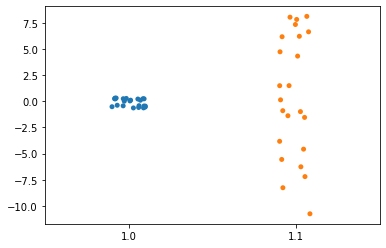

In [161]:

fig, ax = plt.subplots()
no_pola = rel_control1[['1.0']]
no_pola['1.1']= rel_perturb1[['1.0']]
sns.stripplot(data=no_pola)

#plt.savefig('no_polarity_fig3.eps', dpi=300, transparent=True)

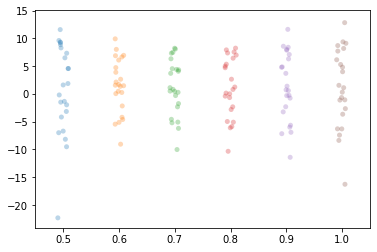

In [178]:
abs_control = (result_control)
rel_control1 = (abs_control - np.mean(abs_control, axis=1)[:,None])

abs_perturb = (result_perturb)
rel_perturb1 = (abs_perturb - np.mean(abs_control, axis=1)[:,None])

fig, ax = plt.subplots()
#sns.stripplot(data=(rel_control1[['0.5', '0.6','0.7','0.8','0.9','1.0']]), jitter=True, ax=ax)
sns.stripplot(data=(rel_perturb1[['0.5', '0.6','0.7','0.8','0.9','1.0']]), jitter=True, alpha=0.3, ax=ax)

In [950]:
import scipy.stats as stat
print(stat.describe(abs_perturb).variance)

[29.98372672 32.46713391 34.47305704 41.54888614 53.13377274 85.61586716]


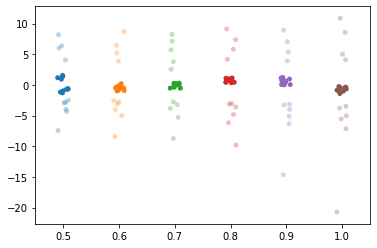

In [944]:
abs_control = (result_control)
rel_control2 = (abs_control - np.mean(abs_control, axis=1)[:,None])

abs_perturb = (result_perturb)
rel_perturb2 = (abs_perturb - np.mean(abs_control, axis=1)[:,None])

fig, ax = plt.subplots()
sns.stripplot(data=(rel_control2), jitter=True, ax=ax)
sns.stripplot(data=(rel_perturb2), jitter=True, alpha=0.3, ax=ax)


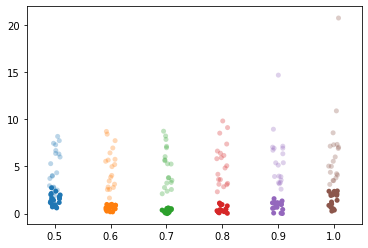

In [980]:
rel_control = rel_control1.append(rel_control2)
rel_perturb = rel_perturb1.append(rel_perturb2)

#rel_control.to_csv("control.csv")
#rel_perturb.to_csv("perturb.csv")

fig, ax = plt.subplots()
sns.stripplot(data=abs(rel_control), jitter=True, ax=ax)
sns.stripplot(data=abs(rel_perturb), jitter=True, alpha=0.3, ax=ax)
#ax.set_rasterized(True)
#fig.savefig("output.pdf", dpi = 300, transparent=False)
#pdftops -eps my.pdf my.eps    commande à faire dans une console

In [978]:
import scipy.stats as stat
print(stat.describe(rel_perturb).variance)
#ecart type
print(np.sqrt(stat.describe(rel_perturb).variance))
print(stat.describe(rel_control).variance)
from scipy.stats import ttest_rel
print(ttest_rel((rel_perturb['0.5']), (rel_perturb['1.0'])))

[25.96191131 28.49288679 29.61078752 34.93386654 42.13898428 60.76690249]
[5.09528324 5.33787287 5.44157951 5.91048784 6.49145471 7.79531285]
[1.81198033 0.45620795 0.11552997 0.12837479 0.90257912 0.62920543]
Ttest_relResult(statistic=2.0954296059000197, pvalue=0.05054072808400278)


In [952]:
sheet=history.retrieve(0)

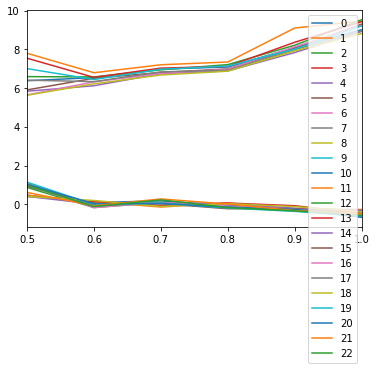

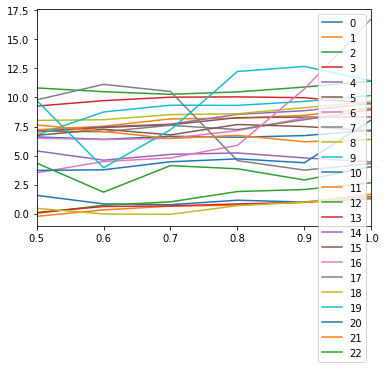

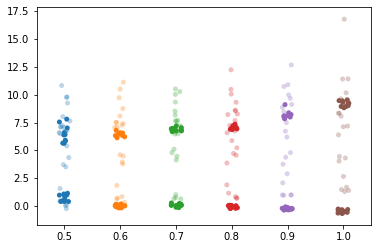

In [693]:
abs_control = abs(result_control)
rel_control = abs_control - np.mean(result_control, axis=1)[:,None]
rel_control.T.plot()

abs_perturb = abs(result_perturb)
rel_perturb = abs_perturb - np.mean(result_control, axis=1)[:,None]
rel_perturb.T.plot()



fig, ax = plt.subplots()
sns.stripplot(data=rel_control, jitter=True, ax=ax)
sns.stripplot(data=rel_perturb, jitter=True, alpha=0.3, ax=ax)

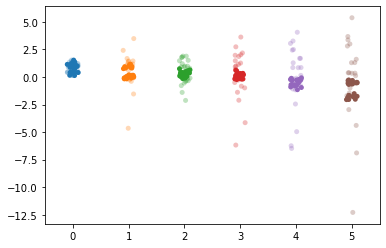

In [675]:
abs_control = abs(result_control)
rel_control = result_control - np.mean(result_control.loc[:,0:5], axis=1)[:,None]

abs_perturb = abs(result_perturb)
rel_perturb = result_perturb - rel_perturb.loc[:,0][:,None]

fig, ax = plt.subplots()
sns.stripplot(data=(rel_control), jitter=True, ax=ax)
sns.stripplot(data=(rel_perturb), jitter=True, alpha=0.3, ax=ax)

/home/admin-suz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


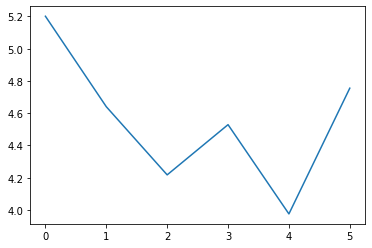

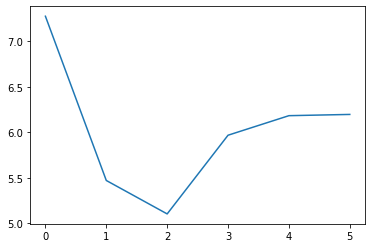

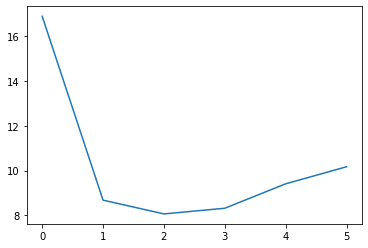

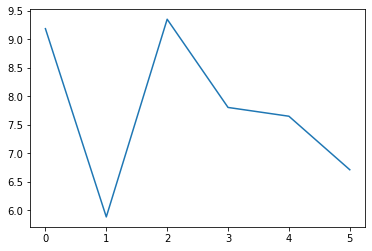

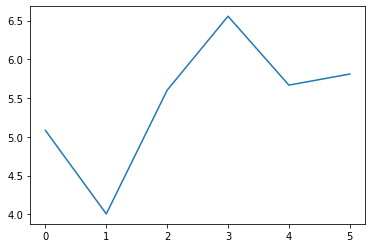

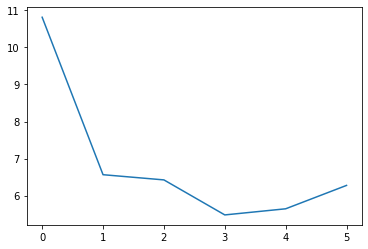

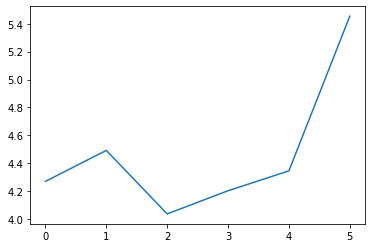

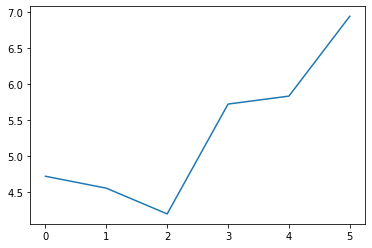

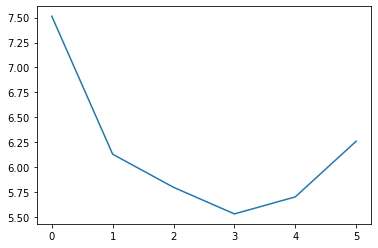

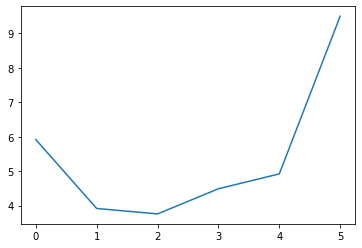

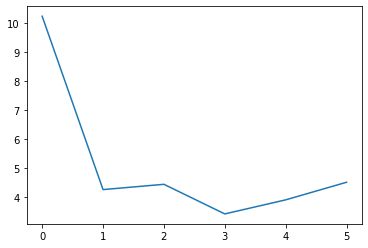

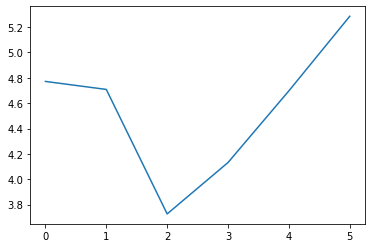

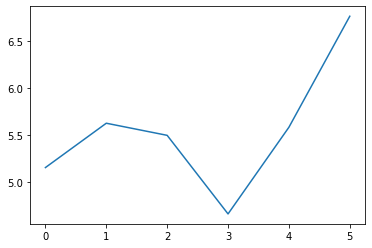

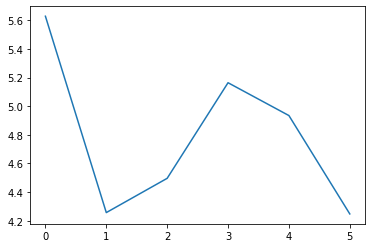

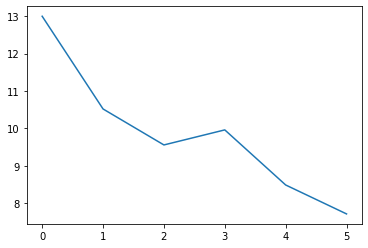

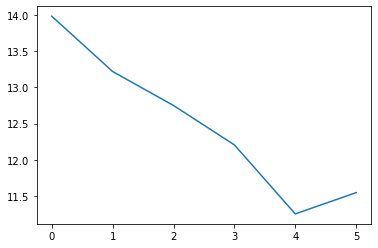

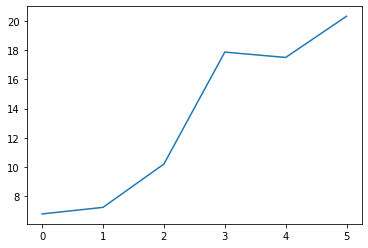

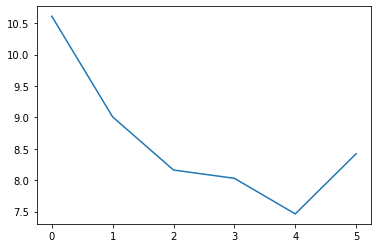

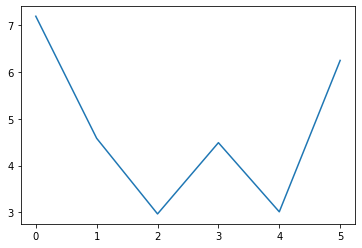

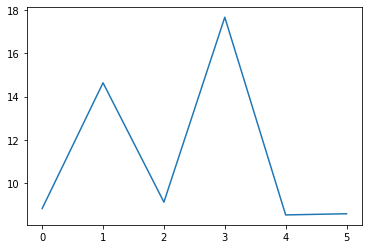

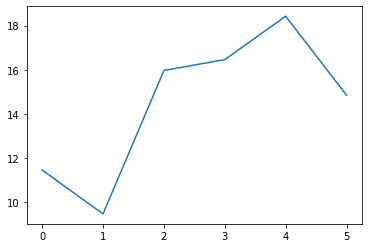

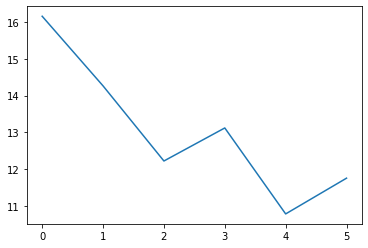

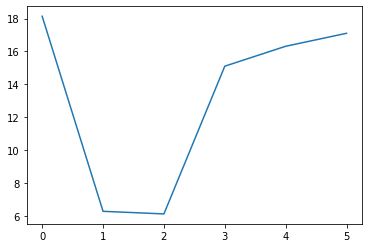

In [564]:
for idx, line in result_perturb.iterrows():
    fig, ax = plt.subplots()
    ax.plot(abs(line))

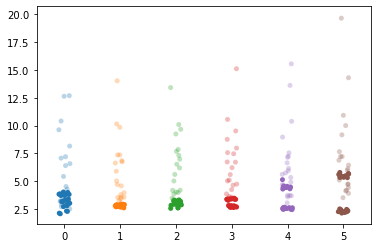

In [600]:
sns.stripplot(data=abs(result_control), jitter=True)
sns.stripplot(data=abs(result_perturb), jitter=True, alpha = 0.3)


In [580]:
import scipy.stats as stat
stat.describe(result_perturb).variance

array([39.12434635, 36.52136458, 41.07678342, 45.44069584, 51.41388436,
       65.86305775])

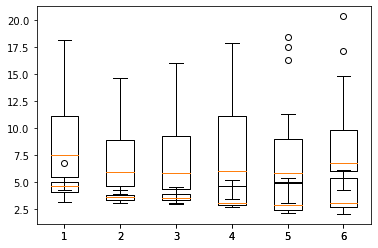

In [566]:
plt.boxplot(np.abs(result_control).T)
plt.boxplot(np.abs(result_perturb).T);

In [567]:
from scipy.stats import ttest_ind
ttest_ind(abs(result_perturb[0]), abs(result_perturb[5]))

Ttest_indResult(statistic=0.4696315351419737, pvalue=0.6409374518353661)

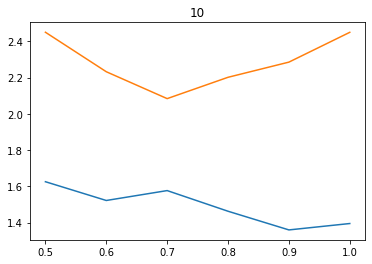

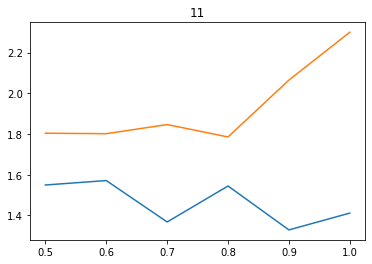

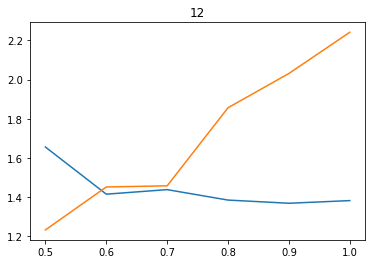

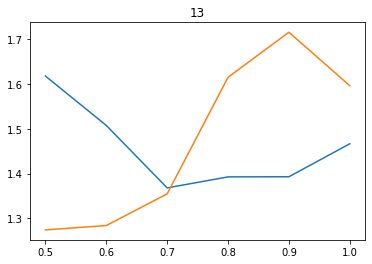

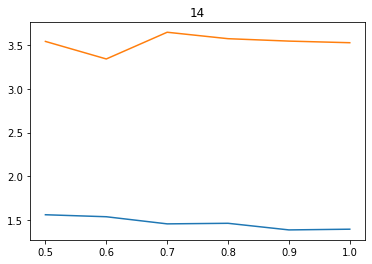

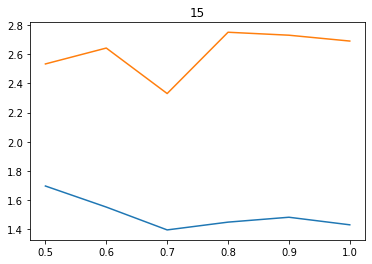

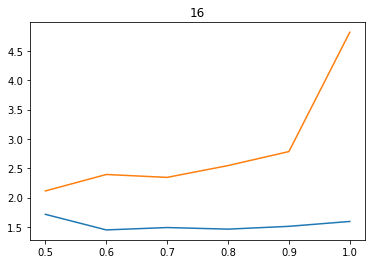

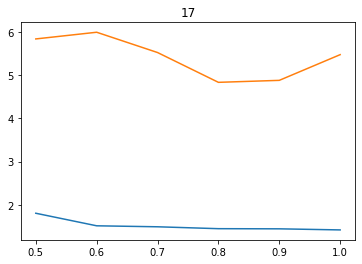

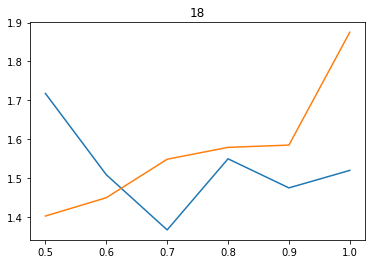

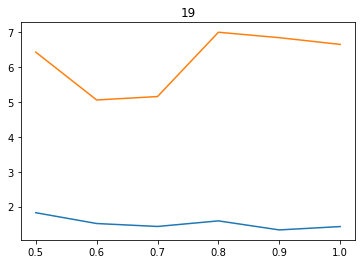

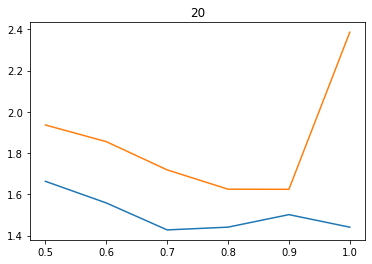

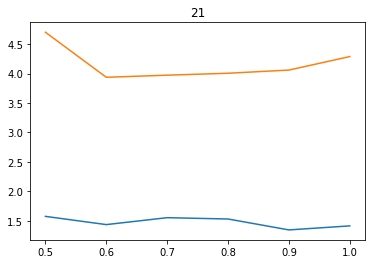

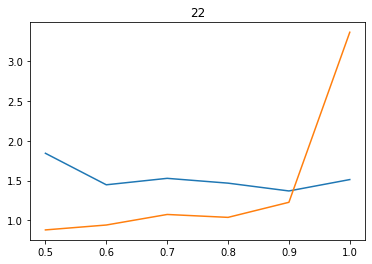

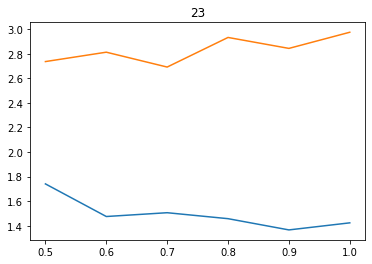

In [427]:

for id, df in datas.groupby('id'):
    fig, ax = plt.subplots()
    df_ = df[df.perturb=='-1'].copy()
    ax.plot(df_.groupby('pola').std().z_depth)
    ax.set_title(id)
    
    df_ = df[df.perturb!='-1'].copy()
    ax.plot(df_.groupby('pola').std().z_depth)
    
    #plt.plot(datas.groupby('pola').mean().z_depth, '.')

/home/admin-suz/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


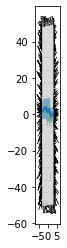

In [486]:
all_measures = measure_fold_whole_sheet(sheet, window=40)

sheet = sheet.extract_bounding_box(z_boundary=(-50,50))
sheet.face_df['depth'] = np.sqrt(
    sheet.face_df['y']**2
    + sheet.face_df['x']**2
)
sheet.edge_df['dlatitude'] = np.arctan2(sheet.edge_df['dy'], sheet.edge_df['dx'])
    
    
fig, ax = sheet_view(sheet, coords=['latitude', 'z'], **draw_specs(sheet))

ax.fill_between(
    all_measures.index,
    all_measures.z_sl,
    all_measures.z_sr,
    alpha=0.5
)
ax.plot(all_measures.index, all_measures.z_depth)

#ax.set_ylim(-40, 40)




(-40, 40)

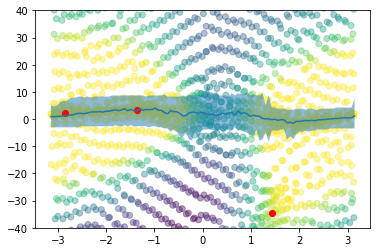

In [493]:
all_measures = measure_fold_whole_sheet(sheet, window=40)

sheet.face_df['latitude'] = np.arctan2(
        sheet.face_df['y'],
        sheet.face_df['x'],
    )


fig, ax = plt.subplots()
ax.scatter(
    sheet.vert_df['latitude'],
    sheet.vert_df['z'],
    c=sheet.vert_df['depth'].clip(upper=10),
    alpha=0.4
)

pos_perturb_latitude = sheet.face_df[sheet.face_df.is_mesoderm==1]['latitude']
pos_perturb_z = sheet.face_df[sheet.face_df.is_mesoderm==1]['z']

ax.fill_between(
    all_measures.index,
    all_measures.z_sl,
    all_measures.z_sr,
    alpha=0.5
)
ax.plot(all_measures.index, all_measures.z_depth)

ax.scatter(
    pos_perturb_latitude,
    pos_perturb_z,
    #c=sheet.vert_df['depth'].clip(upper=10),
    alpha=1,
    c='red'
)

ax.set_ylim(-40, 40)

/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation


/home/admin-suz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0 0 53.0
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation
0 1 53.0
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation
0 2 52.0
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation
0 3 52.0
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation
0 4 54.0
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation
0 5 52.0
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation
0 6 53.0
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation
0 7 53.0
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation
0 8 54.0
/media/admin-suz/Sophie/3_Papie

SystemError: <built-in method write of _io.BufferedWriter object at 0x7f00c2dfea10> returned a result with an error set

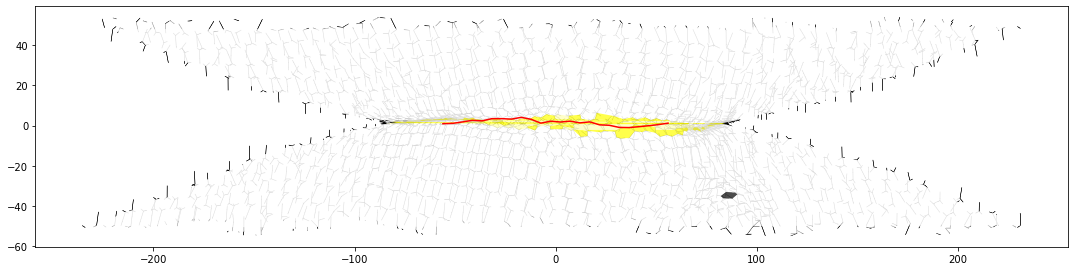

In [476]:
# Graphe production

from matplotlib.colors import ListedColormap
def draw_specs(sheet):
    cmap = ListedColormap(["white", "yellow","red", 
                           "black","black","black"])
    specs = {
        'face': {
            'visible': True,
            'color': sheet.face_df.fold + sheet.face_df.is_mesoderm*3,
            'colormap':cmap,
            'alpha':0.7,
        },
        'edge': {
            'visible': True,
            'color':'black',
        },
        'vert':{
            'visible':False,
            's':100,
            'alpha': 0.3,
            'zorder': 2,
            'color': sheet.vert_df.radial_tension

        }

    }
    return specs


from polarity.toolbox import open_sheet,depth_calculation, all_depth_calculation
from tyssue.draw import sheet_view

for d in range (0,13):
    for i in range (0,24):
        for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[d])) if f.split('_')[-1] == str(i)):
            print(os.path.join(SIM_DIR,list_dir[d]))
            
            history = HistoryHdf5.from_archive(
                os.path.join(os.path.join(SIM_DIR,list_dir[d]),f+'/out.hf5')
            )
            
            t = find_max_depth_time(history, 15)
            
            print(d, i, t)
            sheet = history.retrieve(t)
            
            all_measures = measure_fold_whole_sheet(sheet, nbins=24, window=40)


            sheet_ = sheet.extract_bounding_box(z_boundary=(-50,50))

            sheet_.vert_df['l_rt'] = sheet_.vert_df['rho']*np.arctan2(sheet_.vert_df['y'], sheet_.vert_df['x'])
            sheet_.edge_df['dl_rt'] = np.arctan2(sheet_.edge_df['dy'], sheet_.edge_df['dx'])

            fig, ax = sheet_view(sheet_, coords=[ 'l_rt', 'z',], **draw_specs(sheet_))
            fig.set_size_inches(18.5, 10.5, forward=True)
            
            
            sheet_fold = sheet.extract_bounding_box(z_boundary=(-7, 7))
            r = np.max(np.sqrt(sheet_fold.face_df.x**2 + sheet_fold.face_df.y**2))
            
            ax.plot(all_measures.index*r/3., all_measures.z_depth, 'red')

            plt.savefig(str(d)+'_'+str(i)+'.png', dpi = 300, transparent=False)
            
            plt.close('all')

In [261]:
from tyssue.draw import sheet_view

In [262]:
lats = all_measures.index.to_numpy()

sheet.face_df['latitude'] = np.arctan2(
        sheet.face_df['y'],
        sheet.face_df['x'],
    )
sheet.face_df['depth'] = np.sqrt(
    sheet.face_df['y']**2
    + sheet.face_df['x']**2
)

sheet.face_df['depth'] = sheet.face_df['depth'].max() - sheet.face_df['depth']





In [263]:
lat_bin = pd.cut(sheet.face_df['latitude'], bins=lats, labels=False)

In [265]:
lat_bin

0       74
1       76
2       76
3       69
4       77
        ..
1620    20
1621    45
1622    61
1623    33
1624     2
Name: latitude, Length: 1625, dtype: int64

In [278]:
face_z_slopes = all_measures.iloc[lat_bin.to_numpy()]["z_depth"]
face_z_slopes.index = lat_bin.index

In [282]:
width = 3
is_infold = (
    (sheet.face_df['z'] > face_z_slopes - width)
    & (sheet.face_df['z'] < face_z_slopes + width))

In [283]:
ipv.clear()
fig, mesh = sheet_view(
    sheet,
    mode="3D",
    face={
        "visible": True,
        "color": is_infold.astype(float),
    }
)

fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [258]:
lats

array([-3.14159265e+00, -3.07876080e+00, -3.01592895e+00, -2.95309709e+00,
       -2.89026524e+00, -2.82743339e+00, -2.76460154e+00, -2.70176968e+00,
       -2.63893783e+00, -2.57610598e+00, -2.51327412e+00, -2.45044227e+00,
       -2.38761042e+00, -2.32477856e+00, -2.26194671e+00, -2.19911486e+00,
       -2.13628300e+00, -2.07345115e+00, -2.01061930e+00, -1.94778745e+00,
       -1.88495559e+00, -1.82212374e+00, -1.75929189e+00, -1.69646003e+00,
       -1.63362818e+00, -1.57079633e+00, -1.50796447e+00, -1.44513262e+00,
       -1.38230077e+00, -1.31946891e+00, -1.25663706e+00, -1.19380521e+00,
       -1.13097336e+00, -1.06814150e+00, -1.00530965e+00, -9.42477796e-01,
       -8.79645943e-01, -8.16814090e-01, -7.53982237e-01, -6.91150384e-01,
       -6.28318531e-01, -5.65486678e-01, -5.02654825e-01, -4.39822972e-01,
       -3.76991118e-01, -3.14159265e-01, -2.51327412e-01, -1.88495559e-01,
       -1.25663706e-01, -6.28318531e-02,  4.44089210e-16,  6.28318531e-02,
        1.25663706e-01,  

In [234]:
all_measures.index

Float64Index([               -3.14,  -3.0765656565656565,  -3.0131313131313133,
               -2.9496969696969697,  -2.8862626262626265,   -2.822828282828283,
               -2.7593939393939397,   -2.695959595959596,  -2.6325252525252525,
               -2.5690909090909093,  -2.5056565656565657,   -2.442222222222222,
                -2.378787878787879,  -2.3153535353535353,   -2.251919191919192,
               -2.1884848484848485,  -2.1250505050505053,  -2.0616161616161617,
               -1.9981818181818183,  -1.9347474747474747,  -1.8713131313131313,
               -1.8078787878787879,  -1.7444444444444445,   -1.681010101010101,
               -1.6175757575757577,   -1.554141414141414,  -1.4907070707070706,
               -1.4272727272727272,  -1.3638383838383838,  -1.3004040404040405,
               -1.2369696969696968,  -1.1735353535353534,    -1.11010101010101,
               -1.0466666666666664,  -0.9832323232323232,  -0.9197979797979796,
               -0.8563636363636364,  -0.

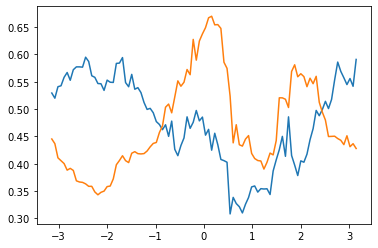

In [231]:
fig, ax = plt.subplots()
ax.plot(all_measures.index, all_measures.slope_left)
ax.plot(all_measures.index, all_measures.slope_right)



In [225]:
def find_max_depth_time(history):

    with pd.HDFStore(history.hf5file, "r") as file:
        v_pos = file.select("vert", columns=["time", "x", "y", "z"]).reset_index()
    center = v_pos[np.abs(v_pos['z']) < 25]
    sq_dpth = center.x**2 + center.y**2
    time = v_pos.loc[sq_dpth.idxmin()]['time']
    return time

In [216]:
history = HistoryHdf5.from_archive(
    '/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20191210-homogenous_Vp_Kp_P0_A0/0.0001_V_10.0_k_4_P0A0_0/out.hf5'
    )

history.datasets["vert"]["time"].unique()

array([0])

In [208]:
history.time_stamps

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149.])